In [148]:
import numpy as np
import matplotlib.pyplot as plt

In [149]:
'''MLE and MAP'''

# for mse 
def loss_mle(x, A, b):  
    return 0.5 * np.linalg.norm(A @ x - b,2)**2

def grad_loss_mle(x, A, b):
    return A.T @ (A @ x - b)

# for map
def loss_map(x, A, b):
    l = .5
    return 0.5 * np.linalg.norm(A @ x - b,2)**2 + l*0.5*np.linalg.norm(x,2)

def grad_loss_map(x, A, b):
    l = 0.5
    return A.T @ (A @ x - b) + l*(A.T @ b)
# ------------------------------------------------------------

# build the vandermonde matrix 
def vandermonde(X,k):
    N = len(X)
    A = np.zeros((N,k))
    for i in range(k):
        A[:,i] = X**i
    return A
# -------------------------------------------------------------

# GD with backtracking 
def backtracking(f, grad_f, x, D):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    A,b = D
    
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(x, A, b), A, b) > f(x, A, b) - c * alpha * np.linalg.norm(grad_f(x, A, b), 2) ** 2: # descending condition 
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

def btGD(f,grad_f,x0,D,kmax,tolf,tolx):
    
    # load the data
    A, b = D
    
    x_val = [x0]
    f_val = [f(x0, A, b)]
    grad_x0 = grad_f(x0, A, b)
    norm_grad_x0 = np.linalg.norm(grad_x0,2)
    grads_val = [grad_x0]
    norm_grads = [norm_grad_x0]
    
    # start iteration
    for k in range(kmax):
        
        # compute the optimal stepsize with backtracking 
        x_old = x_val[k]
        alpha = backtracking(f, grad_f, x_old, D)
        
        # compute the new point  
        x_new = x_old - alpha * grad_f(x_old, A, b)
        x_val.append(x_new)
        
        # compute the value of f(x_new)
        f_val.append(f(x_new, A, b))
        
        # compute the gradient of f in x_new
        grad_x_new = grad_f(x_new, A, b)
        grads_val.append(grad_x_new)
        
        # compute the error
        norm_grad_x_new = np.linalg.norm(grad_x_new,2)
        norm_grads.append(norm_grad_x_new)
        
        # first condition 
        if norm_grad_x_new < tolf * norm_grad_x0:
            break
        
        # second condition
        if np.linalg.norm(x_new - x_old,2) < tolx:
            break
        
    return x_val, k, f_val, grads_val, norm_grads
# --------------------------------------------------------------

# stochastic gradient descent 
def SGD(loss,grad_loss,w0,D,batch_size = 10,n_epoch = 50,lr = 1e-3):
    
    # load the dataset
    A,b = D
    
    # initial iteration
    w = w0
    results = [w]
    
    # dimension
    N, d = A.shape
    
    # number of batch per epoch
    n = N // batch_size 
    
    # initialize some arrays 
    grad_loss_w = grad_loss(w, A, b)
    loss_val = [loss(w, A, b)]
    grad_loss_val = [grad_loss_w]
    norm_grad_loss_val = [np.linalg.norm(grad_loss_w, 2)]
    
    for epoch in range(n_epoch):
        
        # set the index 
        idx = np.arange(N)
        np.random.shuffle(idx)
        
        for k in range(n):
            
            # select the batch
            A_temp = A[idx[k*batch_size:(k+1)*batch_size], :]
            b_temp = b[idx[k*batch_size:(k+1)*batch_size]]
            
            # gradient descent iteration
            w = w - lr * grad_loss(w, A_temp, b_temp)
            
        # update the arrays 
        results.append(w)
        loss_val.append(loss(w, A, b))
        grad_loss_w = grad_loss(w, A, b)
        grad_loss_val.append(grad_loss_w)
        norm_grad_loss_val.append(np.linalg.norm(grad_loss_w, 2))
    
    return results, loss_val, grad_loss_val, norm_grad_loss_val
# --------------------------------------------------------------------

def mle(D, descent_type= "NE"):
    '''
    Computes the Maximum Likelihood estimation in different ways: 
    NE = normal equations
    GD = gradient descent
    SGD = stochastic gradient descent
    '''
    X, Y = D
    N, d = X.shape
    
    if descent_type == "NE":
        theta_mle = np.linalg.solve(X.T@X, X.T@Y)
        
    elif descent_type == "GD":
        x0 = np.zeros((d,))
        x_val, k, f_val, grads_val, norm_grads = btGD(loss_mle,grad_loss_mle,x0,D,kmax = 1000,tolf = 1e-6,tolx= 1e-6)
        theta_mle = x_val[-1]
        
    elif descent_type == "SGD":
        w0 = np.zeros((d,))
        results, loss_val, grad_loss_val, norm_grad_loss_val = SGD(loss_mle,grad_loss_mle,w0,D,batch_size = 10,n_epoch = 20,lr = 1e-3)
        theta_mle = results[-1]
        
    else:
        raise Exception("Invalid value for descent_type. descent_type can be NE, GD or SGD")    
    
    return theta_mle

def map(D, lmbda, descent_type= "NE"):
    '''
    Computes the Maximum A Posteriori estimation in different ways: 
    NE = normal equations
    GD = gradient descent
    SGD = stochastic gradient descent
    '''
    A, b = D
    N, d = A.shape
    
    if descent_type == "NE":
        theta_map = np.linalg.solve(A.T@A + lmbda * np.identity(d), A.T@b)
        
    elif descent_type == "GD":
        x0 = np.zeros((d,))
        x_val, k, f_val, grads_val, norm_grads = btGD(loss_map,grad_loss_map,x0,D,kmax = 1000,tolf = 1e-6,tolx= 1e-6)
        theta_map = x_val[-1]
        
    elif descent_type == "SGD":
        w0 = np.zeros((d,))
        results, loss_val, grad_loss_val, norm_grad_loss_val = SGD(loss_map,grad_loss_map,w0,D,batch_size = 10,n_epoch = 20,lr = 1e-3)
        theta_map = results[-1]
    
    else:
        raise Exception("Invalid value for descent_type. descent_type can be NE, GD or SGD")    
    
    return theta_map

In [150]:
'''prepare the true dataset'''

# hyperparameters
Ntrue = 350
ktrue = 7
theta_true = np.ones((ktrue,))
a, b = 0, 1
sigma = 1

# train
Xtrue = np.random.uniform(a,b,(Ntrue,))
vander = vandermonde(Xtrue,ktrue)
Ytrue = vander @ theta_true + np.random.normal(0,sigma**2,(Ntrue,))
Dtrue = (Xtrue, Ytrue)

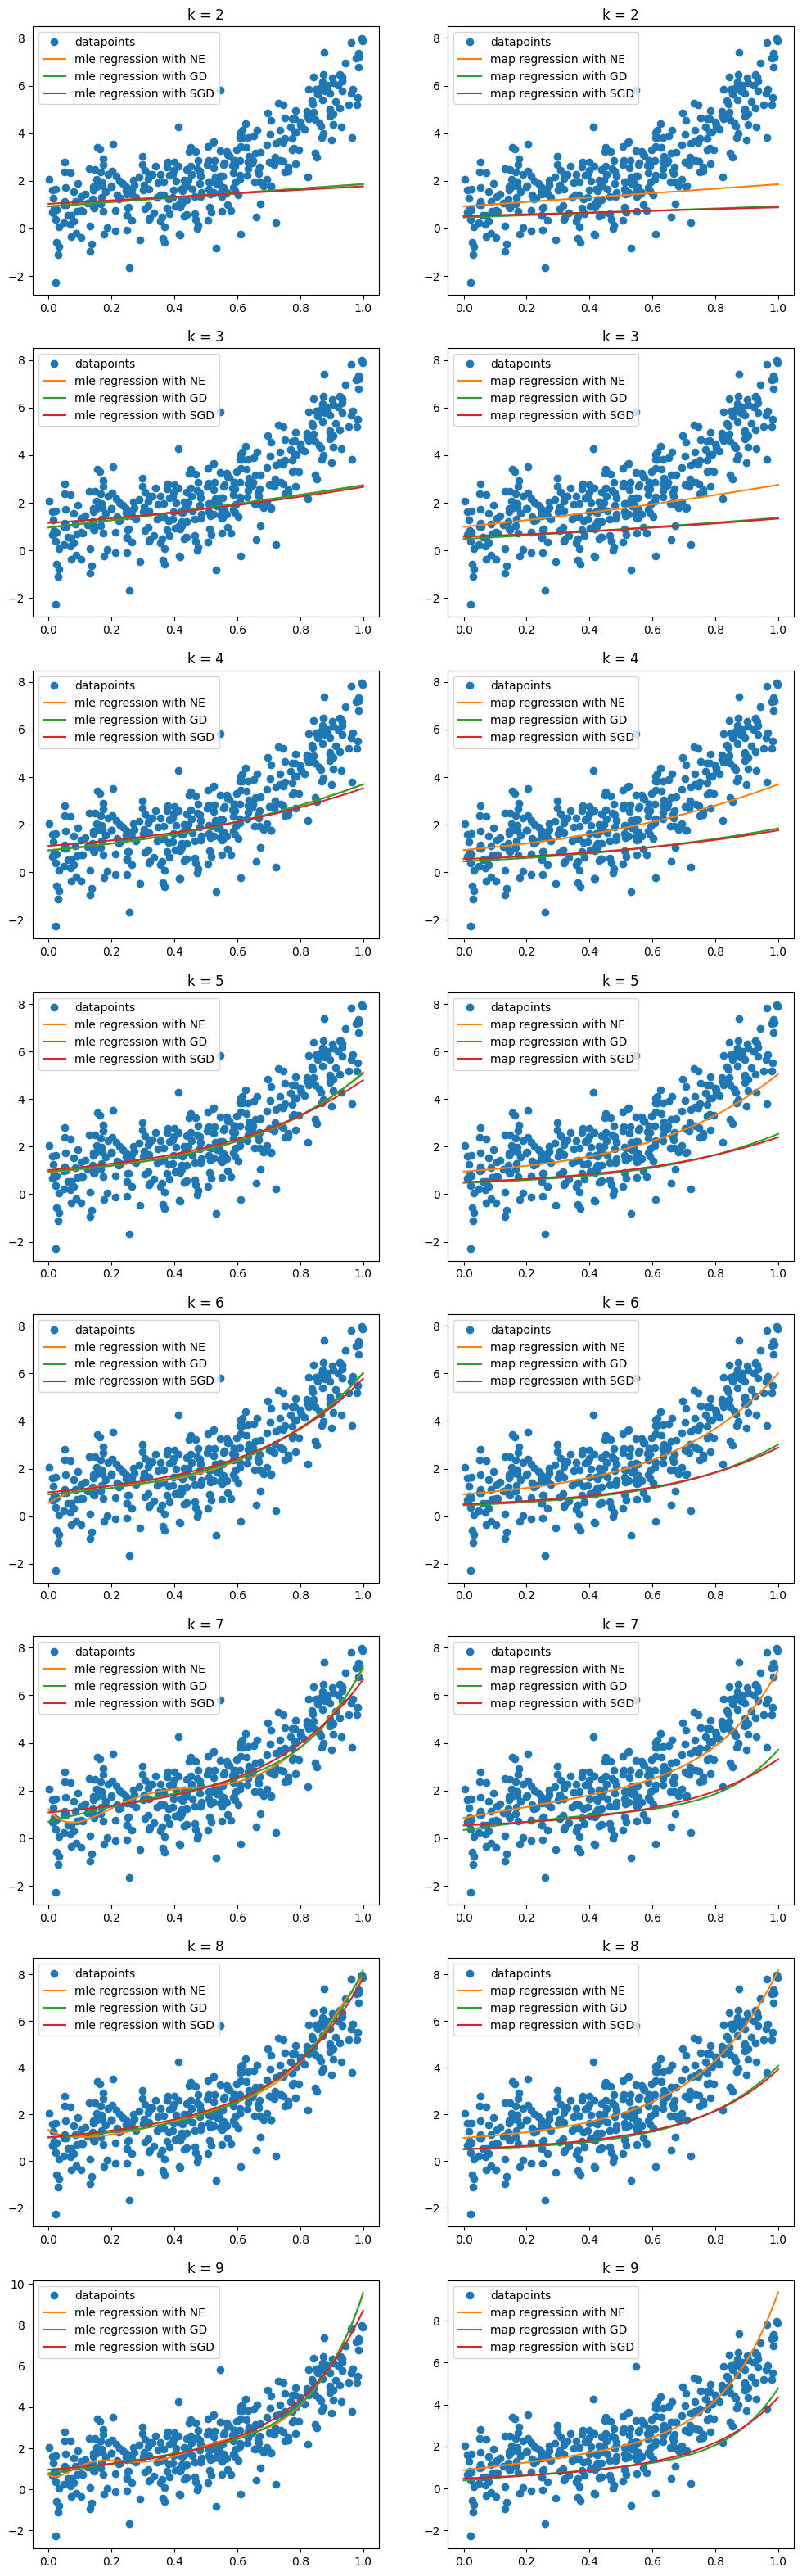

In [151]:
'''compare mle and map with different k and different methods'''

# train and test size 
Ntrain = 350
Ntest = 100

# set the dimension
kmin = 2
kmax = 10

# set the possible methods for learning 
methods = ['NE', 'GD', 'SGD']

plt.figure(figsize=(12,40))
pos = 1

mle_train_error = []
mle_test_error = []
map_train_error = []
map_test_error = []

for k in range(kmin,kmax):
    
    # set the true solution
    theta_true = np.ones((k,))
    
    # train set
    Xtrain = np.random.uniform(a, b, (Ntrain,))
    vander_train = vandermonde(Xtrain, k)
    Ytrain = vander_train @ theta_true + np.random.normal(0, sigma**2, (Ntrain,))
    Dtrain = (vander_train, Ytrain)

    # test set
    Xtest = np.reshape(np.linspace(a, b, Ntest), (Ntest, ))
    vander_test = vandermonde(Xtest, k)
    Ytest = vander_test @ theta_true + np.random.normal(0, sigma**2, (Ntest,))
    Dtest = (vander_test, Ytest)
    
    # store errors for each method 
    mle_train_error_method = []
    mle_test_error_method = []
    map_train_error_method = []
    map_test_error_method = []
    
    # prepare the plot 
    plt.subplot(kmax - kmin, 2, pos)
    plt.plot(Xtrue, Ytrue, 'o')
    plt.title(f"k = {k}")
    
    plt.subplot(kmax - kmin, 2, pos+1)
    plt.plot(Xtrue, Ytrue, 'o')
    plt.title(f"k = {k}")
    
    # loop over descent type 
    for method in methods:
        
        # mle and map results 
        theta_mle = mle(Dtrain, descent_type=method)
        theta_map = map(Dtrain, lmbda=0.5, descent_type=method)
    
        # make prediction for mle 
        Ytrain_pred_mle = vander_train @ theta_mle
        Ytest_pred_mle = vander_test @ theta_mle
    
        # make prediction for map
        Ytrain_pred_map = vander_train @ theta_map
        Ytest_pred_map = vander_test @ theta_map
        
        # mle error 
        mle_train_error_method.append(np.mean(np.square(Ytrain_pred_mle - Ytrain)))
        mle_test_error_method.append(np.mean(np.square(Ytest_pred_mle - Ytest)))
    
        # map error 
        map_train_error_method.append(np.mean(np.square(Ytrain_pred_map - Ytrain)))
        map_test_error_method.append(np.mean(np.square(Ytest_pred_map - Ytest)))
    
        # plot for mle
        plt.subplot(kmax - kmin, 2, pos)
        plt.plot(Xtest, vander_test @ theta_mle)
        
        # plot for map
        plt.subplot(kmax - kmin, 2, pos + 1)
        plt.plot(Xtest, vander_test @ theta_map)
        
    mle_train_error.append(mle_train_error_method)
    mle_test_error.append(mle_test_error_method)
    map_train_error.append(map_train_error_method)
    map_test_error.append(map_test_error_method)
        
    plt.subplot(kmax - kmin, 2, pos)
    plt.legend(['datapoints'] + [f"mle regression with {method}" for method in methods])
    
    plt.subplot(kmax - kmin, 2, pos + 1)
    plt.legend(['datapoints'] + [f"map regression with {method}" for method in methods])
    
    pos += 2

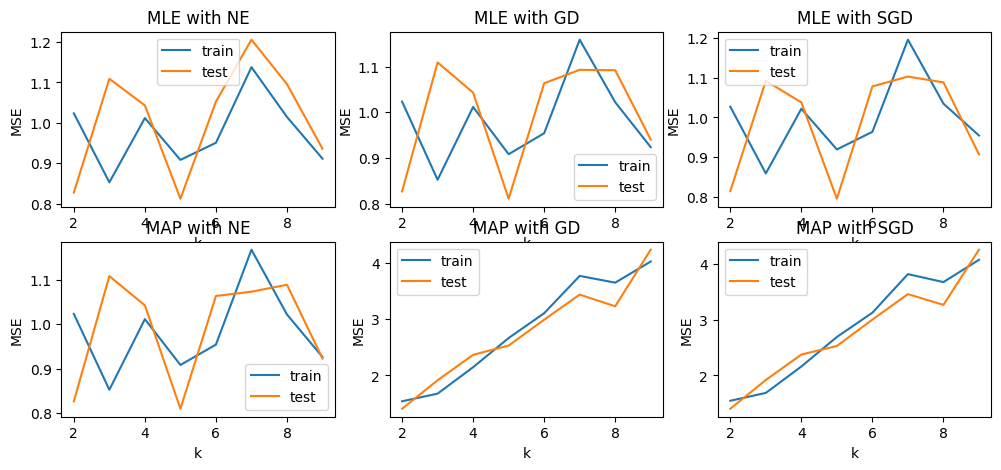

In [152]:
''' plot the train and test errors '''

plt.figure(figsize=(12,5))

for i in range(3):
    
    # plot the errors for mle 
    plt.subplot(2, 3, i+1)
    plt.plot(range(kmin,kmax), [err_met[i] for err_met in mle_train_error])
    plt.plot(range(kmin,kmax), [err_met[i] for err_met in mle_test_error])
    plt.title(f"MLE with {methods[i]}")
    plt.xlabel('k')
    plt.ylabel('MSE')
    plt.legend(['train', 'test'])

for i in range(3):

    # plot the errors for mle 
    plt.subplot(2, 3, 3 + i+1)
    plt.plot(range(kmin,kmax), [err_met[i] for err_met in map_train_error])
    plt.plot(range(kmin,kmax), [err_met[i] for err_met in map_test_error])
    plt.title(f"MAP with {methods[i]}")
    plt.xlabel('k')
    plt.ylabel('MSE')
    plt.legend(['train', 'test'])

In [153]:
'''MLE and MAP'''

# for mse 
def loss_mle(x, A, b):  
    return 0.5 * np.linalg.norm(A @ x - b,2)**2

def grad_loss_mle(x, A, b):
    return A.T @ (A @ x - b)

# for map
def loss_map(x, A, b, l):
    return 0.5 * np.linalg.norm(A @ x - b,2)**2 + l*0.5*np.linalg.norm(x,2)

def grad_loss_map(x, A, b, l):
    return A.T @ (A @ x - b) + l*(A.T @ b)
# ------------------------------------------------------------

# build the vandermonde matrix 
def vandermonde(X,k):
    N = len(X)
    A = np.zeros((N,k))
    for i in range(k):
        A[:,i] = X**i
    return A
# -------------------------------------------------------------

# GD with backtracking 
def backtracking(f, grad_f, x, D, l):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    A,b = D
    
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(x, A, b, l), A, b, l) > f(x, A, b, l) - c * alpha * np.linalg.norm(grad_f(x, A, b, l), 2) ** 2: # descending condition 
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

def btGD(f,grad_f,x0,D,l,kmax,tolf,tolx):
    
    # load the data
    A, b = D
    
    x_val = [x0]
    f_val = [f(x0, A, b, l)]
    grad_x0 = grad_f(x0, A, b, l)
    norm_grad_x0 = np.linalg.norm(grad_x0,2)
    grads_val = [grad_x0]
    norm_grads = [norm_grad_x0]
    
    # start iteration
    for k in range(kmax):
        
        # compute the optimal stepsize with backtracking 
        x_old = x_val[k]
        alpha = backtracking(f, grad_f, x_old, D, l)
        
        # compute the new point  
        x_new = x_old - alpha * grad_f(x_old, A, b, l)
        x_val.append(x_new)
        
        # compute the value of f(x_new)
        f_val.append(f(x_new, A, b, l))
        
        # compute the gradient of f in x_new
        grad_x_new = grad_f(x_new, A, b, l)
        grads_val.append(grad_x_new)
        
        # compute the error
        norm_grad_x_new = np.linalg.norm(grad_x_new,2)
        norm_grads.append(norm_grad_x_new)
        
        # first condition 
        if norm_grad_x_new < tolf * norm_grad_x0:
            break
        
        # second condition
        if np.linalg.norm(x_new - x_old,2) < tolx:
            break
        
    return x_val, k, f_val, grads_val, norm_grads
# --------------------------------------------------------------

# stochastic gradient descent 
def SGD(loss,grad_loss,w0,D,l,batch_size = 10,n_epoch = 50,lr = 1e-3):
    
    # load the dataset
    A,b = D
    
    # initial iteration
    w = w0
    results = [w]
    
    # dimension
    N, d = A.shape
    
    # number of batch per epoch
    n = N // batch_size 
    
    # initialize some arrays 
    grad_loss_w = grad_loss(w, A, b, l)
    loss_val = [loss(w, A, b, l)]
    grad_loss_val = [grad_loss_w]
    norm_grad_loss_val = [np.linalg.norm(grad_loss_w, 2)]
    
    for epoch in range(n_epoch):
        
        # set the index 
        idx = np.arange(N)
        np.random.shuffle(idx)
        
        for k in range(n):
            
            # select the batch
            A_temp = A[idx[k*batch_size:(k+1)*batch_size], :]
            b_temp = b[idx[k*batch_size:(k+1)*batch_size]]
            
            # gradient descent iteration
            w = w - lr * grad_loss(w, A_temp, b_temp, l)
            
        # update the arrays 
        results.append(w)
        loss_val.append(loss(w, A, b, l))
        grad_loss_w = grad_loss(w, A, b, l)
        grad_loss_val.append(grad_loss_w)
        norm_grad_loss_val.append(np.linalg.norm(grad_loss_w, 2))
    
    return results, loss_val, grad_loss_val, norm_grad_loss_val
# --------------------------------------------------------------------

def mle(D, descent_type= "NE"):
    '''
    Computes the Maximum Likelihood estimation in different ways: 
    NE = normal equations
    GD = gradient descent
    SGD = stochastic gradient descent
    '''
    X, Y = D
    N, d = X.shape
    
    if descent_type == "NE":
        theta_mle = np.linalg.solve(X.T@X, X.T@Y)
        
    elif descent_type == "GD":
        x0 = np.zeros((d,))
        x_val, k, f_val, grads_val, norm_grads = btGD(loss_mle,grad_loss_mle,x0,D,kmax = 1000,tolf = 1e-6,tolx= 1e-6)
        theta_mle = x_val[-1]
        
    elif descent_type == "SGD":
        w0 = np.zeros((d,))
        results, loss_val, grad_loss_val, norm_grad_loss_val = SGD(loss_mle,grad_loss_mle,w0,D,batch_size = 10,n_epoch = 20,lr = 1e-3)
        theta_mle = results[-1]
        
    else:
        raise Exception("Invalid value for descent_type. descent_type can be NE, GD or SGD")    
    
    return theta_mle

def map(D, l, descent_type= "NE"):
    '''
    Computes the Maximum A Posteriori estimation in different ways: 
    NE = normal equations
    GD = gradient descent
    SGD = stochastic gradient descent
    '''
    A, b = D
    N, d = A.shape
    
    if descent_type == "NE":
        theta_map = np.linalg.solve(A.T@A + l * np.identity(d), A.T@b)
        
    elif descent_type == "GD":
        x0 = np.zeros((d,))
        x_val, k, f_val, grads_val, norm_grads = btGD(loss_map,grad_loss_map,x0,D,l,kmax = 1000,tolf = 1e-6,tolx= 1e-6)
        theta_map = x_val[-1]
        
    elif descent_type == "SGD":
        w0 = np.zeros((d,))
        results, loss_val, grad_loss_val, norm_grad_loss_val = SGD(loss_map,grad_loss_map,w0,D,l,batch_size = 10,n_epoch = 20,lr = 1e-3)
        theta_map = results[-1]
    
    else:
        raise Exception("Invalid value for descent_type. descent_type can be NE, GD or SGD")    
    
    return theta_map

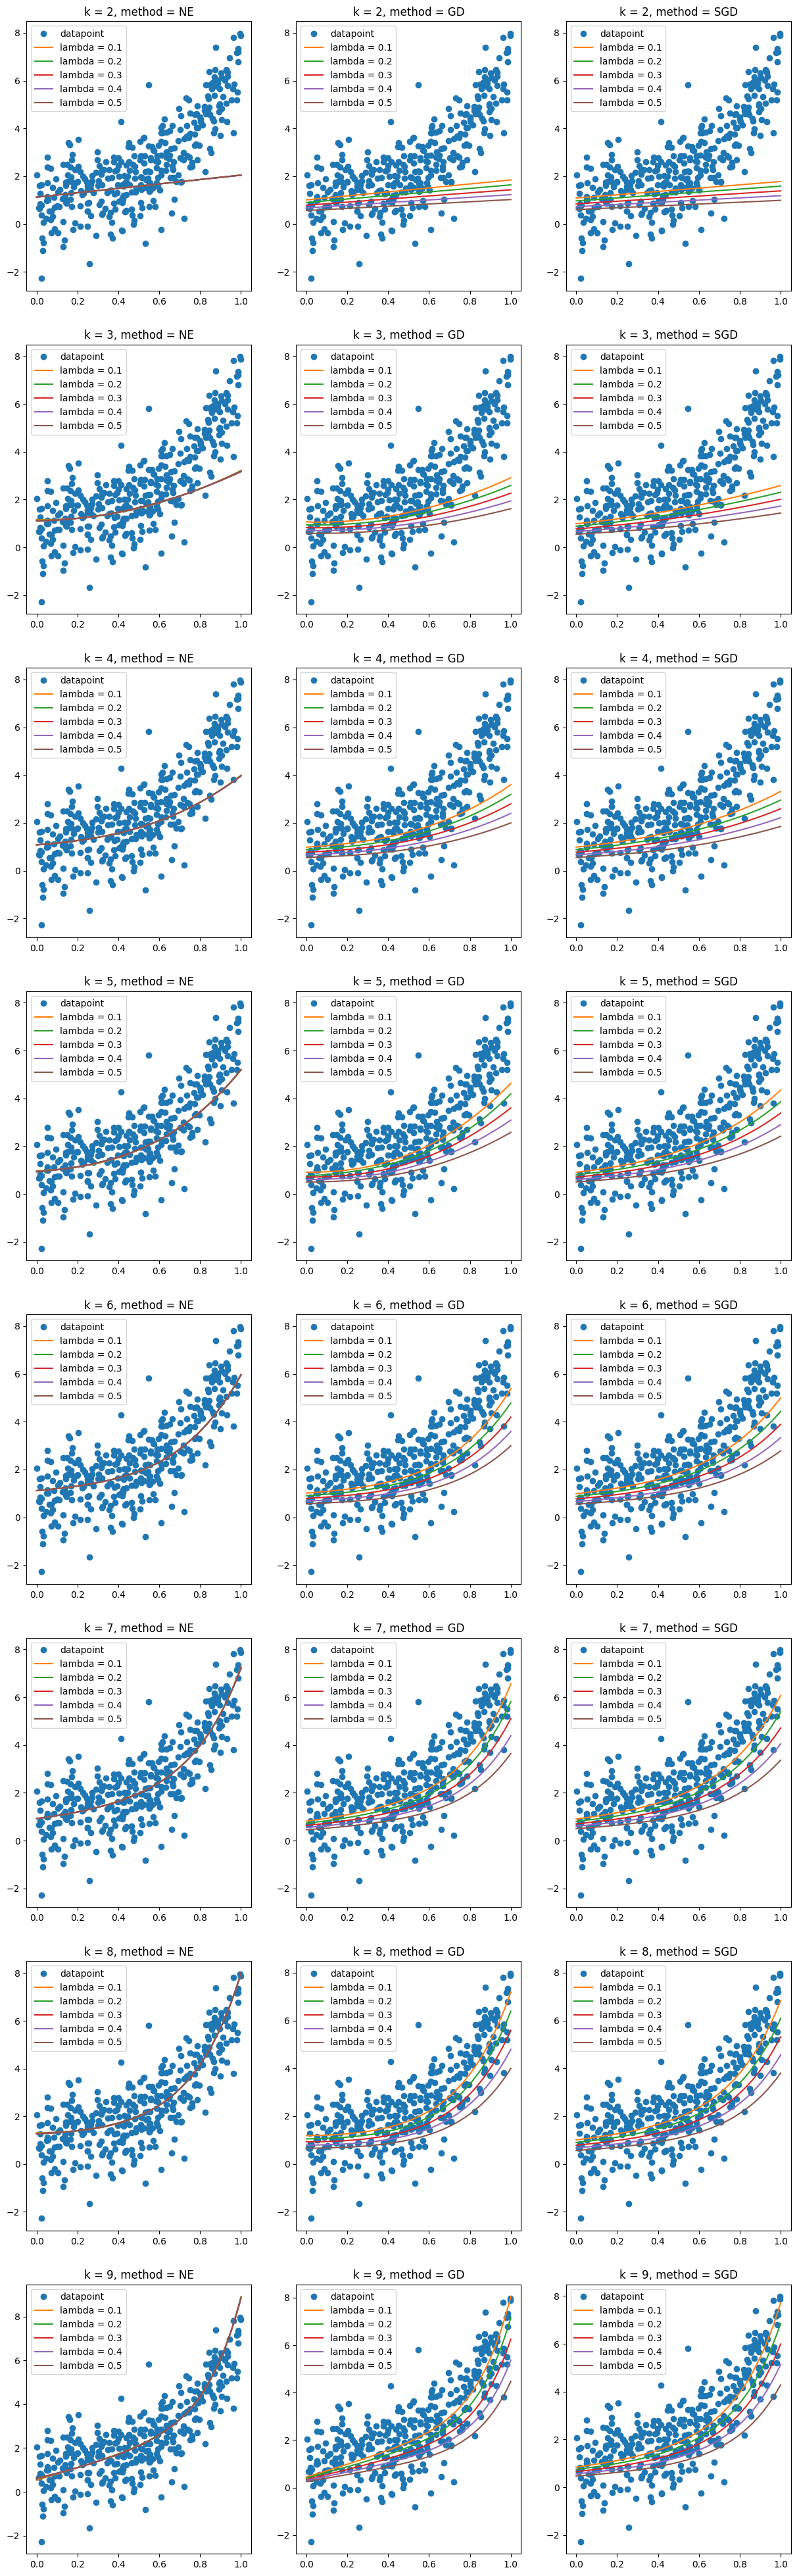

In [154]:
'''MAP analysis with different lamda values, k and methods'''

# set the dimension
kmin = 2
kmax = 10

# set the possible methods for learning 
methods = ['NE', 'GD', 'SGD']

# set the possible lambda values 
ls = [0.1, 0.2, 0.3, 0.4, 0.5]

plt.figure(figsize=(15,50))
pos = 1

mle_train_error = []
mle_test_error = []
map_train_error = []
map_test_error = []

for k in range(kmin,kmax):
    
    # set the true solution
    theta_true = np.ones((k,))
    
    # train set
    Xtrain = np.random.uniform(a, b, (Ntrain,))
    vander_train = vandermonde(Xtrain, k)
    Ytrain = vander_train @ theta_true + np.random.normal(0, sigma**2, (Ntrain,))
    Dtrain = (vander_train, Ytrain)

    # test set
    Xtest = np.reshape(np.linspace(a, b, Ntest), (Ntest, ))
    vander_test = vandermonde(Xtest, k)
    Ytest = vander_test @ theta_true + np.random.normal(0, sigma**2, (Ntest,))
    Dtest = (vander_test, Ytest)
    
    # store errors for each method 
    map_train_error_method = []
    map_test_error_method = []
    
    # loop over descent type 
    for method in methods:
        
        # store errors for each lambda values 
        map_train_error_method_lambda = []
        map_test_error_method_lambda = []
        
        # prepare the plot 
        plt.subplot(8, 3, pos)
        plt.plot(Xtrue, Ytrue, 'o')
        
        # loop over lambda values 
        for l in ls:
        
            # map results 
            theta_map = map(Dtrain, l, descent_type=method)
    
            # make prediction for map
            Ytrain_pred_map = vander_train @ theta_map
            Ytest_pred_map = vander_test @ theta_map
    
            # map error 
            map_train_error_method_lambda.append(np.mean(np.square(Ytrain_pred_map - Ytrain)))
            map_test_error_method_lambda.append(np.mean(np.square(Ytest_pred_map - Ytest)))
    
            # plot the result
            plt.subplot(8, 3, pos)
            plt.plot(Xtest, Ytest_pred_map)
            
        # complete the plot 
        plt.subplot(8, 3, pos)
        plt.title(f"k = {k}, method = {method}")
        plt.legend(['datapoint'] + [f"lambda = {l}" for l in ls])
        
        pos += 1
            
        map_train_error_method.append(map_train_error_method_lambda)
        map_test_error_method.append(map_test_error_method_lambda)
        
    map_train_error.append(map_train_error_method)
    map_test_error.append(map_test_error_method)

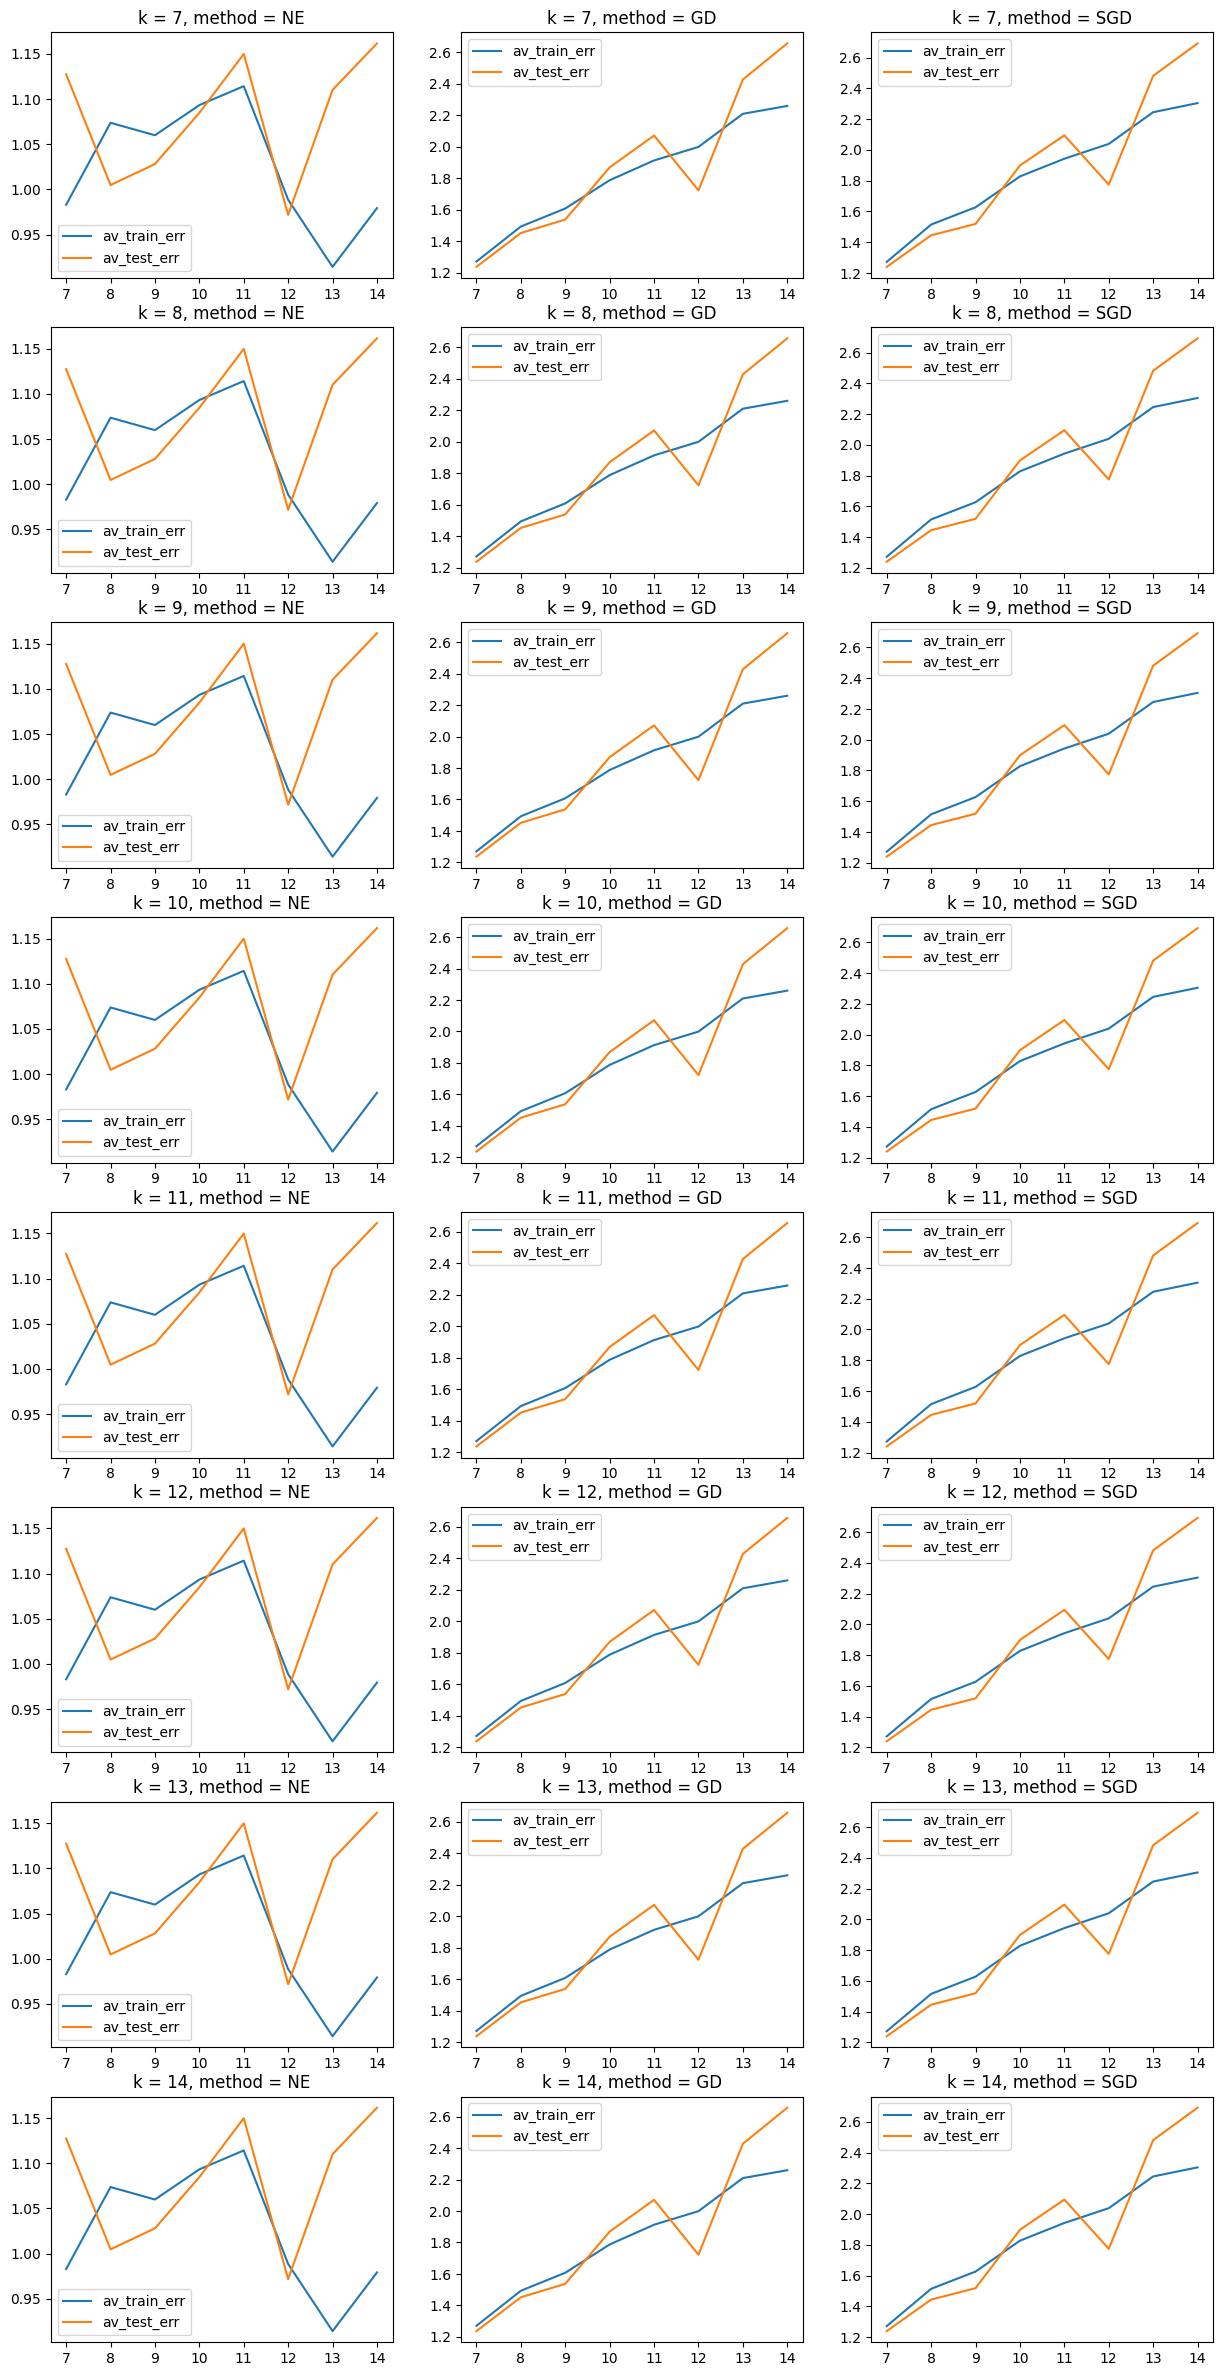

In [171]:
''' plot the train and test (average, with respect to lambda values) errors'''

plt.figure(figsize=(15, 30))
pos = 1

# loop over dimension
for i in range(kmin, kmax):
    # loop over method 
    for j in range(3):
        # loop over lambda values (train error)
        av_train_err = np.zeros((8,))
        for k in range(5):
            av_train_err += np.array([err_lambda[k] for err_method in map_train_error for err_lambda in err_method][j:40:3])

        plt.subplot(8, 3, pos)
        plt.plot(range(kmin,kmax), av_train_err / 5)  
         
        av_test_err = np.zeros((8,))
        # loop over lambda values (test error)
        for k in range(5):
            av_test_err += np.array([err_lambda[k] for err_method in map_test_error for err_lambda in err_method][j:40:3])
            
        plt.subplot(8, 3, pos)
        plt.plot(range(kmin,kmax), av_test_err / 5)
        
        plt.subplot(8, 3, pos)
        plt.title(f"k = {i}, method = {methods[j]}")
        plt.legend(['av_train_err', 'av_test_err'])
        pos += 1
plt.show()

In [156]:
'''MLE and MAP'''

# for mse 
def loss_mle(x, A, b):  
    return 0.5 * np.linalg.norm(A @ x - b,2)**2

def grad_loss_mle(x, A, b):
    return A.T @ (A @ x - b)

# for map
def loss_map(x, A, b):
    l = 0.2
    return 0.5 * np.linalg.norm(A @ x - b,2)**2 + l*0.5*np.linalg.norm(x,2)

def grad_loss_map(x, A, b):
    l = 0.2
    return A.T @ (A @ x - b) + l*(A.T @ b)
# ------------------------------------------------------------

# build the vandermonde matrix 
def vandermonde(X,k):
    N = len(X)
    A = np.zeros((N,k))
    for i in range(k):
        A[:,i] = X**i
    return A
# -------------------------------------------------------------

# GD with backtracking 
def backtracking(f, grad_f, x, D):
    """
    This function is a simple implementation of the backtracking algorithm for
    the GD (Gradient Descent) method.
    
    f: function. The function that we want to optimize.
    grad_f: function. The gradient of f(x).
    x: ndarray. The actual iterate x_k.
    """
    A,b = D
    
    alpha = 1
    c = 0.8
    tau = 0.25
    
    while f(x - alpha * grad_f(x, A, b), A, b) > f(x, A, b) - c * alpha * np.linalg.norm(grad_f(x, A, b), 2) ** 2: # descending condition 
        alpha = tau * alpha
        
        if alpha < 1e-3:
            break
    return alpha

def btGD(f,grad_f,x0,D,kmax,tolf,tolx):
    
    # load the data
    A, b = D
    
    x_val = [x0]
    f_val = [f(x0, A, b)]
    grad_x0 = grad_f(x0, A, b)
    norm_grad_x0 = np.linalg.norm(grad_x0,2)
    grads_val = [grad_x0]
    norm_grads = [norm_grad_x0]
    
    # start iteration
    for k in range(kmax):
        
        # compute the optimal stepsize with backtracking 
        x_old = x_val[k]
        alpha = backtracking(f, grad_f, x_old, D)
        
        # compute the new point  
        x_new = x_old - alpha * grad_f(x_old, A, b)
        x_val.append(x_new)
        
        # compute the value of f(x_new)
        f_val.append(f(x_new, A, b))
        
        # compute the gradient of f in x_new
        grad_x_new = grad_f(x_new, A, b)
        grads_val.append(grad_x_new)
        
        # compute the error
        norm_grad_x_new = np.linalg.norm(grad_x_new,2)
        norm_grads.append(norm_grad_x_new)
        
        # first condition 
        if norm_grad_x_new < tolf * norm_grad_x0:
            break
        
        # second condition
        if np.linalg.norm(x_new - x_old,2) < tolx:
            break
        
    return x_val, k, f_val, grads_val, norm_grads
# --------------------------------------------------------------

# stochastic gradient descent 
def SGD(loss,grad_loss,w0,D,batch_size = 10,n_epoch = 50,lr = 1e-3):
    
    # load the dataset
    A,b = D
    
    # initial iteration
    w = w0
    results = [w]
    
    # dimension
    N, d = A.shape
    
    # number of batch per epoch
    n = N // batch_size 
    
    # initialize some arrays 
    grad_loss_w = grad_loss(w, A, b)
    loss_val = [loss(w, A, b)]
    grad_loss_val = [grad_loss_w]
    norm_grad_loss_val = [np.linalg.norm(grad_loss_w, 2)]
    
    for epoch in range(n_epoch):
        
        # set the index 
        idx = np.arange(N)
        np.random.shuffle(idx)
        
        for k in range(n):
            
            # select the batch
            A_temp = A[idx[k*batch_size:(k+1)*batch_size], :]
            b_temp = b[idx[k*batch_size:(k+1)*batch_size]]
            
            # gradient descent iteration
            w = w - lr * grad_loss(w, A_temp, b_temp)
            
        # update the arrays 
        results.append(w)
        loss_val.append(loss(w, A, b))
        grad_loss_w = grad_loss(w, A, b)
        grad_loss_val.append(grad_loss_w)
        norm_grad_loss_val.append(np.linalg.norm(grad_loss_w, 2))
    
    return results, loss_val, grad_loss_val, norm_grad_loss_val
# --------------------------------------------------------------------

def mle(D, descent_type= "NE"):
    '''
    Computes the Maximum Likelihood estimation in different ways: 
    NE = normal equations
    GD = gradient descent
    SGD = stochastic gradient descent
    '''
    X, Y = D
    N, d = X.shape
    
    if descent_type == "NE":
        theta_mle = np.linalg.solve(X.T@X, X.T@Y)
        
    elif descent_type == "GD":
        x0 = np.zeros((d,))
        x_val, k, f_val, grads_val, norm_grads = btGD(loss_mle,grad_loss_mle,x0,D,kmax = 1000,tolf = 1e-6,tolx= 1e-6)
        theta_mle = x_val[-1]
        
    elif descent_type == "SGD":
        w0 = np.zeros((d,))
        results, loss_val, grad_loss_val, norm_grad_loss_val = SGD(loss_mle,grad_loss_mle,w0,D,batch_size = 10,n_epoch = 20,lr = 1e-3)
        theta_mle = results[-1]
        
    else:
        raise Exception("Invalid value for descent_type. descent_type can be NE, GD or SGD")    
    
    return theta_mle

def map(D, lmbda, descent_type= "NE"):
    '''
    Computes the Maximum A Posteriori estimation in different ways: 
    NE = normal equations
    GD = gradient descent
    SGD = stochastic gradient descent
    '''
    A, b = D
    N, d = A.shape
    
    if descent_type == "NE":
        theta_map = np.linalg.solve(A.T@A + lmbda * np.identity(d), A.T@b)
        
    elif descent_type == "GD":
        x0 = np.zeros((d,))
        x_val, k, f_val, grads_val, norm_grads = btGD(loss_map,grad_loss_map,x0,D,kmax = 1000,tolf = 1e-6,tolx= 1e-6)
        theta_map = x_val[-1]
        
    elif descent_type == "SGD":
        w0 = np.zeros((d,))
        results, loss_val, grad_loss_val, norm_grad_loss_val = SGD(loss_map,grad_loss_map,w0,D,batch_size = 10,n_epoch = 20,lr = 1e-3)
        theta_map = results[-1]
    
    else:
        raise Exception("Invalid value for descent_type. descent_type can be NE, GD or SGD")    
    
    return theta_map

def error(theta_true, theta):
    
    # store the dimensions
    n = theta_true.shape[0]
    N = theta.shape[0]
    
    # fill theta_true 
    theta_true = np.concatenate((theta_true,np.zeros((N-n,))))
    
    # compute the relative error
    err = np.linalg.norm(theta_true - theta,2) / np.linalg.norm(theta_true,2)
    
    return err

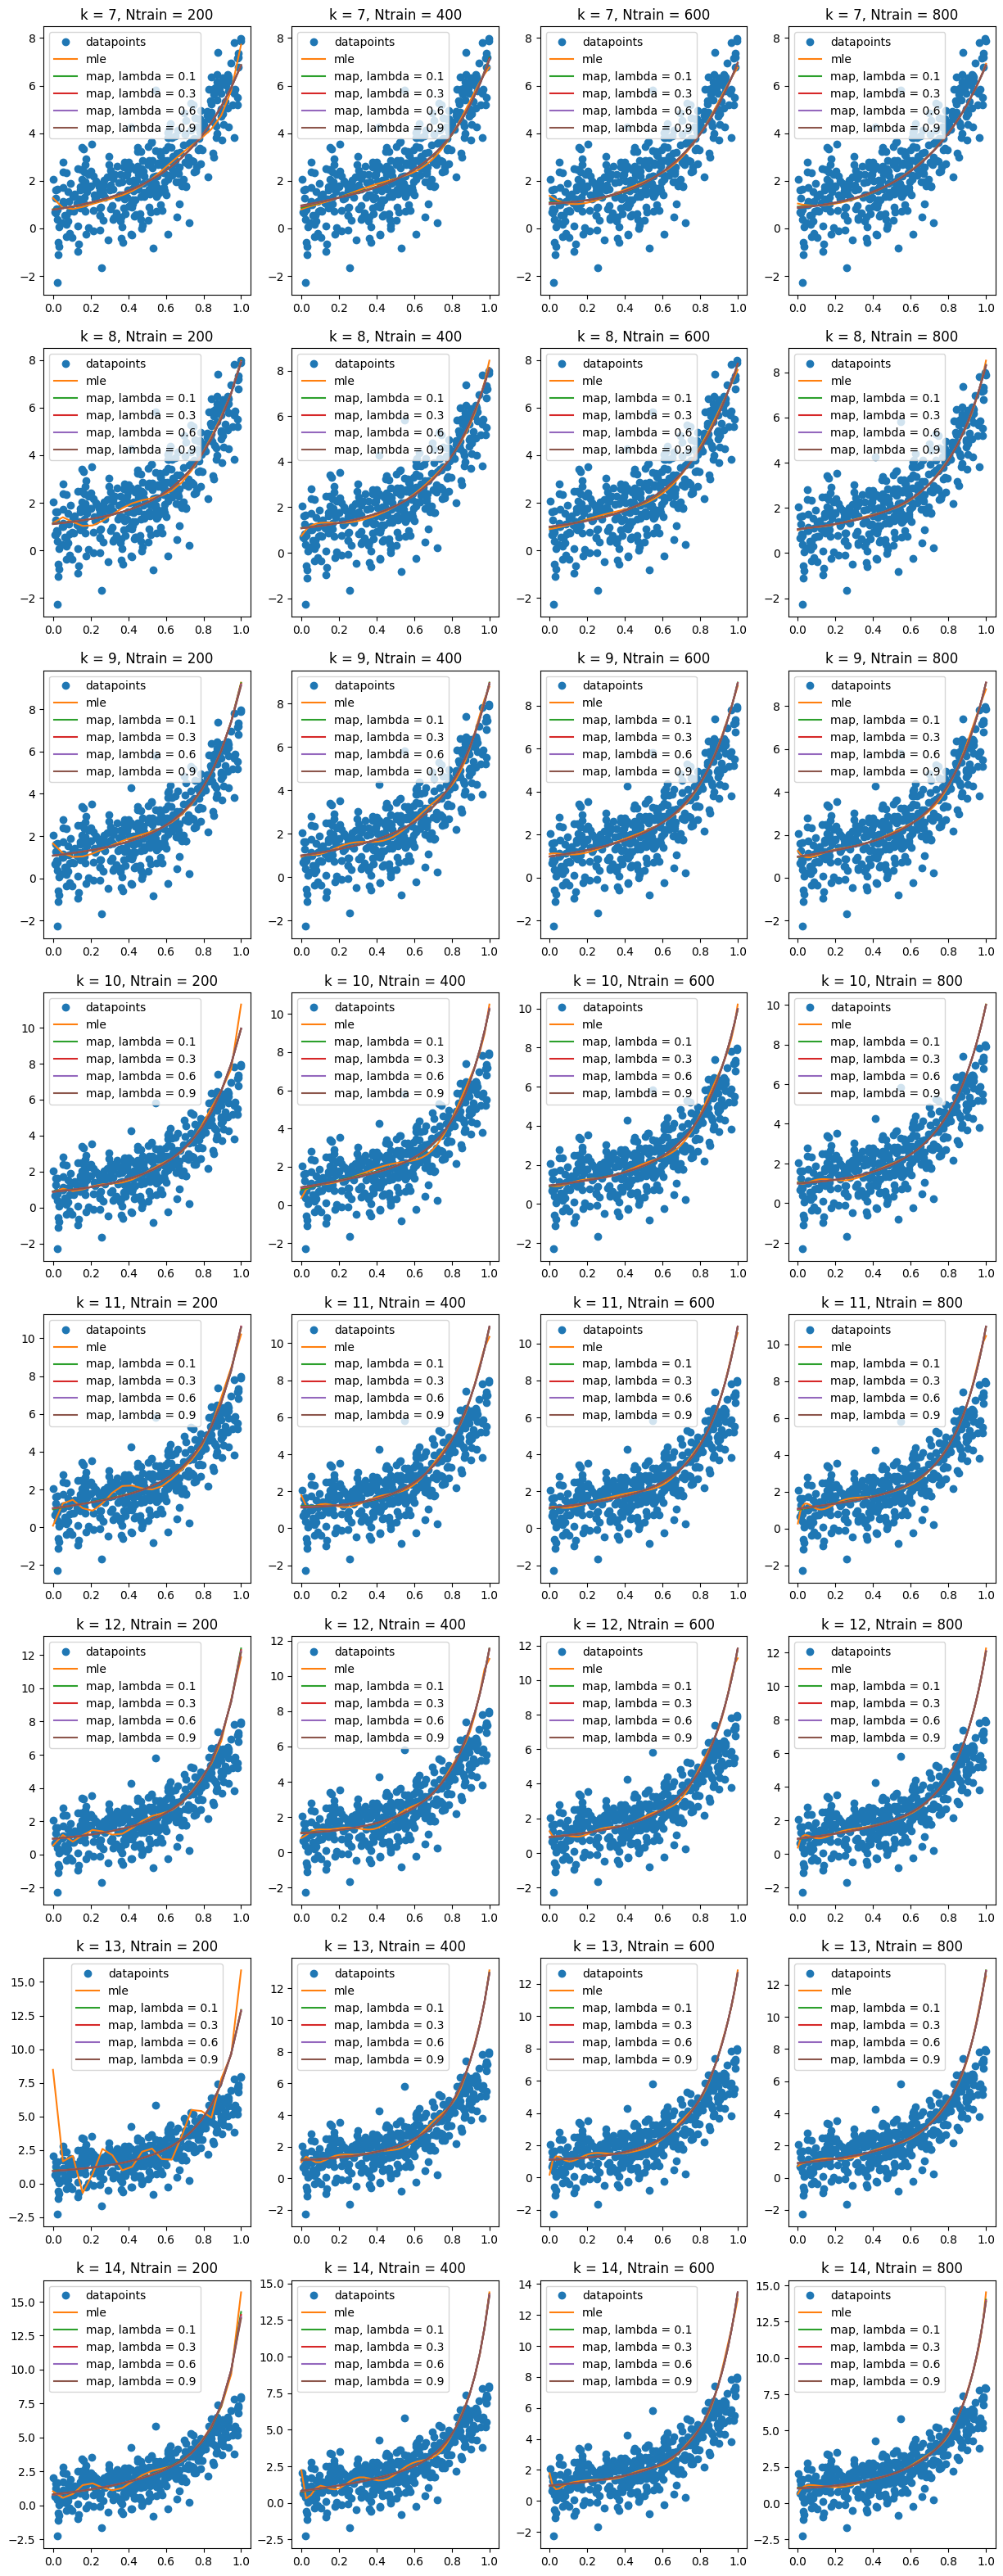

In [164]:
'''mle and map analysis with different train size, k and lambda values'''

# train size 
Ntrain_min = 200
Ntrain_max = 800

# lambda values
ls = [0.1, 0.3, 0.6, 0.9]

# set the dimension (remember ktrue = 7)
kmin = 7
kmax = 15

# set the real solution (k = 7)
theta_true_above_all = np.ones((ktrue,))

plt.figure(figsize=(15,40))
pos = 1

err_mle = []
err_map = []

for k in range(kmin,kmax):
    
    for Ntrain in range(Ntrain_min, Ntrain_max + 1, 200):
        
        Ntest = Ntrain // 10
    
        # set the true solution
        theta_true = np.ones((k,))
    
        # train set
        Xtrain = np.random.uniform(a, b, (Ntrain,))
        vander_train = vandermonde(Xtrain, k)
        Ytrain = vander_train @ theta_true + np.random.normal(0, sigma**2, (Ntrain,))
        Dtrain = (vander_train, Ytrain)

        # test set
        Xtest = np.reshape(np.linspace(a, b, Ntest), (Ntest, ))
        vander_test = vandermonde(Xtest, k)
        Ytest = vander_test @ theta_true + np.random.normal(0, sigma**2, (Ntest,))
        Dtest = (vander_test, Ytest)
            
        # mle result
        theta_mle = mle(Dtrain, descent_type='NE')
        
        # mle prediction
        Ytrain_pred_mle = vander_train @ theta_mle
        Ytest_pred_mle = vander_test @ theta_mle
        
        # mle error 
        err_mle.append(error(theta_true_above_all, theta_mle))
        
        err_map_lambda = []
        
        # plot the results 
        plt.subplot(8, 4, pos)
        plt.plot(Xtrue, Ytrue, 'o')
        plt.plot(Xtest, Ytest_pred_mle)
        
        for l in ls:
            
            # map ressult
            theta_map = map(Dtrain, l, descent_type='NE')

            # make prediction for map
            Ytrain_pred_map = vander_train @ theta_map
            Ytest_pred_map = vander_test @ theta_map
        
            # map error lambda
            err_map_lambda.append(error(theta_true_above_all, theta_map))
            
            # plot the results
            plt.plot(Xtest, Ytest_pred_map)
        
        # map error
        err_map.append(err_map_lambda)
    
        plt.title(f"k = {k}, Ntrain = {Ntrain}")
        plt.legend(['datapoints', 'mle'] + [f"map, lambda = {l}" for l in ls])

        pos += 1

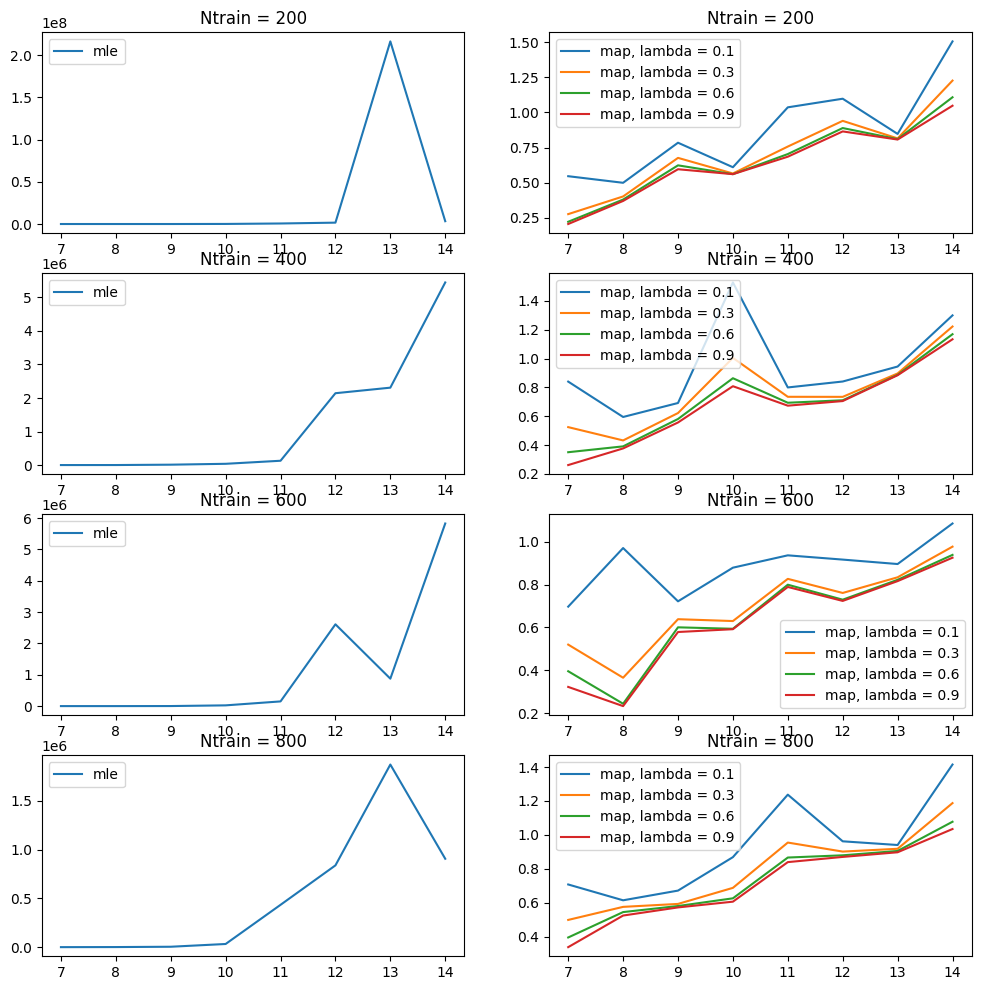

In [170]:
''' plot the relative errors for theta_map and theta_mle, for different training size, with respect to k'''

plt.figure(figsize=(12, 12))
pos = 1

# loop over train size
for n in range(4):
    
    # plot the mle arror 
    plt.subplot(4, 2, pos)
    plt.plot(range(kmin, kmax), err_mle[n:32:4])
    plt.title(f"Ntrain = {200*(n+1)}")
    plt.legend(['mle'])
    
    pos += 1
        
    # loop over lambda values 
    for i in range(len(ls)):
            
        # plot the map error 
        plt.subplot(4, 2, pos)
        plt.plot(range(kmin, kmax), [err_lambda[i] for err_lambda in err_map][n:32:4])
        
    plt.title(f"Ntrain = {200*(n+1)}")
    plt.legend([f"map, lambda = {l}" for l in ls])
        
    pos += 1
        
plt.show()